## This notebook experiments with the python package "timeseries-generator"

In [1]:
#from timeseries_generator import LinearTrend, Generator, WhiteNoise, RandomFeatureFactor
#import pandas as pd
#%matplotlib inline


import pandas as pd
from pandas._libs.tslibs.timestamps import Timestamp
from timeseries_generator.external_factors import CountryGdpFactor, EUIndustryProductFactor
from timeseries_generator import Generator, HolidayFactor, LinearTrend, RandomFeatureFactor, SinusoidalFactor, WeekdayFactor, WhiteNoise


# Setting up parameters

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='date'>)

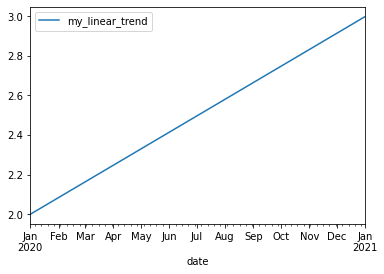

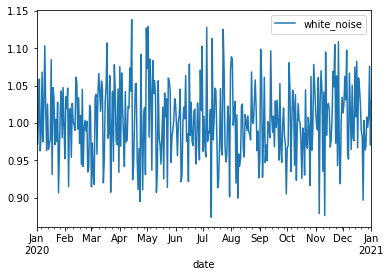

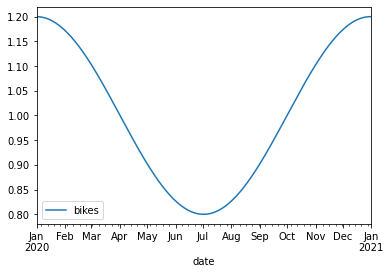

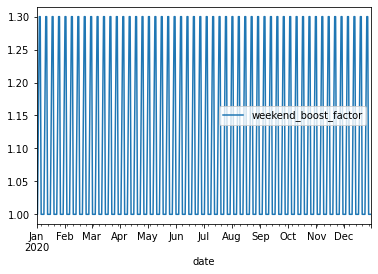

In [2]:
# The python package "timeseries_generator" implements day-increment granularity.
# The columns will have to be manually
start_date = Timestamp("01-01-2020")
end_date = Timestamp("01-01-2021")

features_dict = {
        "station": ["station_1", "station_2"],
        "product": ["bikes"]
}


linear_trend = LinearTrend(coef=1.0, offset=1., col_name="my_linear_trend")
white_noise = WhiteNoise(stdev_factor=0.05)

seasonality = SinusoidalFactor(
    feature="product",
    col_name="product_seasonal_trend_factor",
    feature_values={
        "bikes": {
            "wavelength": 365.,
            "amplitude": 0.2,
            "phase": 365/4,
            "mean": 1.
        }
    }
)


weekday_factor = WeekdayFactor(
    col_name="weekend_boost_factor",
    factor_values={4: 1.15, 5: 1.3, 6: 1.3}  # Here we assign a factor of 1.15 to Friday, and 1.3 to Sat/Sun 
)


# Plotting the parameters
linear_trend.plot(start_date=start_date, end_date=end_date)
white_noise.plot(start_date=start_date, end_date=end_date)
seasonality.plot(start_date=start_date, end_date=end_date)
weekday_factor.plot(start_date=start_date, end_date=end_date)  # Using a smaller timerange here to keep the plot viewable



# Creating generator

In [3]:
g: Generator = Generator(
    factors={
        linear_trend,
        seasonality,
        white_noise,
        #weekday_factor,
    },
    features=features_dict,
    date_range=pd.date_range(start=start_date, end=end_date),
    base_value=10
)
    
df = g.generate()

<AxesSubplot:xlabel='date'>

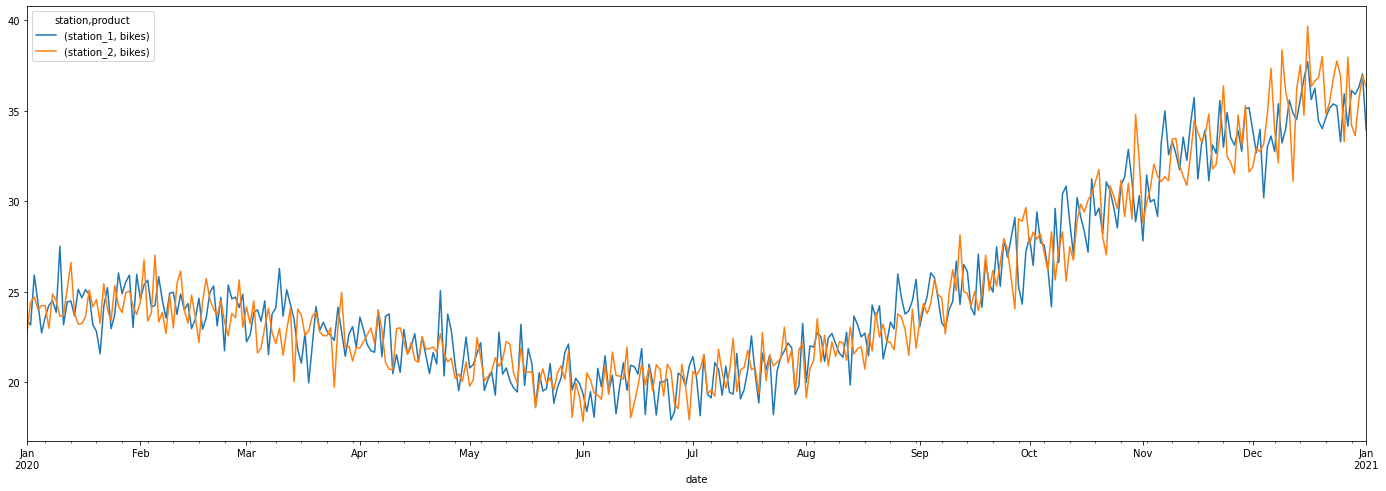

In [4]:

plot_df = df.set_index('date')
plot_df[['station', 'product', 'value']].pivot(columns=['station', 'product'], values='value').plot(figsize=(24,8))

In [5]:
df.head()


,date,station,product,base_amount,my_linear_trend,white_noise,product_seasonal_trend_factor,total_factor,value
0,2020-01-01,station_1,bikes,10,2.000000,0.974348,1.200000,2.338436,23.384363
1,2020-01-01,station_2,bikes,10,2.000000,0.949065,1.200000,2.277757,22.777569
2,2020-01-02,station_1,bikes,10,2.002725,0.964110,1.199970,2.316959,23.169590
3,2020-01-02,station_2,bikes,10,2.002725,1.016194,1.199970,2.442129,24.421285
4,2020-01-03,station_1,bikes,10,2.005450,1.077397,1.199881,2.592542,25.925416


# AR Fitting

In [6]:
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

## First, visualize the decomposition

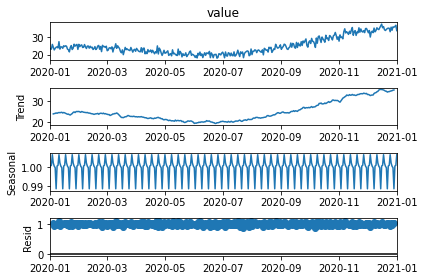

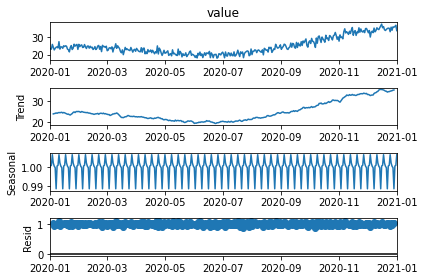

In [7]:
series = df.copy()
# filtering out the other stations. 
series = series[series["station"] == "station_1"]

# make first column a datetime format
series.index = pd.to_datetime(series.date)
# filter out factors "collapses the columns" into a value
series = series['value']

series.head()

decomp = seasonal_decompose(series, model='multiplicative')
decomp.plot()


## Attempt to fit the data

In [8]:
train = series.iloc[:math.floor(series.shape[0] * 0.8)]
test  = series.iloc[math.ceil(series.shape[0] * 0.8):]

print("Shape of train is: ", train.shape)
print("Shape of test is: ", test.shape)

Shape of train is:  (293,)
Shape of test is:  (73,)


In [9]:
stepwise_model = auto_arima(series, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.78 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1659.057, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1463.202, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.20 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1569.234, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1433.505, Time=0.54 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.12 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.12 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1544.803, Time=0.45 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1399.923, Time=0.80 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1435.069, Time=0.37 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=8.69 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.10 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1389.287, Time=0.97 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=1428.2